# Deep learning for timeseries

This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff) provided by Francois Chollet. 

The exact formulation of the problem will be as follows: given data covering the previous
five days and sampled once per hour, can we predict the temperature in 24 hours?

## Import data

- We first need to download the data


- Mac user: use [homebrew](https://brew.sh) to install the following packages:

```bash
brew install openssl
```

```bash
brew install wget
```

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

--2022-05-05 15:33:33--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Auflösen des Hostnamens s3.amazonaws.com (s3.amazonaws.com)… 54.231.165.120
Verbindungsaufbau zu s3.amazonaws.com (s3.amazonaws.com)|54.231.165.120|:443 … verbunden.
HTTP-Anforderung gesendet, auf Antwort wird gewartet … 200 OK
Länge: 13565642 (13M) [application/zip]
Wird in »jena_climate_2009_2016.csv.zip« gespeichert.

jena_climate_2009_2 100%[===================>]  12,94M  12,5MB/s    in 1,0s    

2022-05-05 15:33:34 (12,5 MB/s) - »jena_climate_2009_2016.csv.zip« gespeichert [13565642/13565642]



In [2]:
!unzip jena_climate_2009_2016.csv.zip

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


- Inspecting the data of the Jena weather dataset

In [3]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


- This outputs a count of 420,551 lines of data (each line is a timestep: a record of a
date and 14 weather-related values), as well as the header.

- Now, convert all 420,551 lines of data into NumPy arrays: one array for the temperature
(in degrees Celsius), and another one for the rest of the data—the features we
will use to predict future temperatures. Note that we discard the “Date Time” column.

In [4]:
import numpy as np

temperature = np.zeros((len(lines),))

raw_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

- Plotting the temperature timeseries

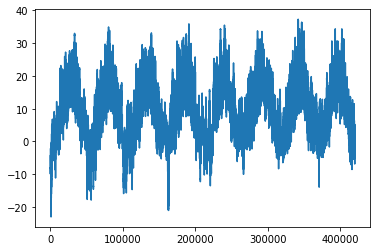

In [5]:
from matplotlib import pyplot as plt

plt.plot(range(len(temperature)), temperature)

- Plotting the first 10 days of the temperature timeseries

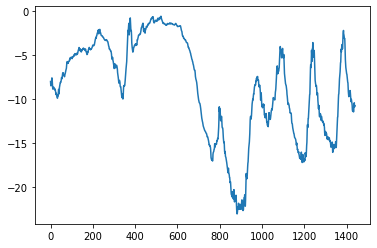

In [6]:
plt.plot(range(1440), temperature[:1440])

## Data split

- In all our experiments, we’ll use the first 50% of the data for training, the following
25% for validation, and the last 25% for testing

- When working with timeseries data, it’s important to use validation and test data that is more recent than the training
data, because you’re trying to predict the future given the past, not the reverse,
and your validation/test splits should reflect that

- Computing the number of samples we'll use for each data split:

In [9]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))

num_test_samples = len(raw_data) - num_train_samples - num_val_samples

print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


## Normalizing the data

- We’re going to use the first 210,225 timesteps as
training data, so we’ll compute the mean and standard deviation only on this fraction
of the data.

In [10]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean

std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

## Batch the data

- Next, let’s create a Dataset object that yields batches of data from the past five days
along with a target temperature 24 hours in the future. 

- Because the samples in the dataset are highly redundant (sample N and sample N + 1 will have most of their timesteps in common), it would be wasteful to explicitly allocate memory for every sample.

- Instead, we’ll generate the samples on the fly while only keeping in memory the original
raw_data and temperature arrays, and nothing more.

- We could write a Python generator to do this, but there’s a built-in dataset
utility in Keras that does just that (timeseries_dataset_from_array()), so we can
save ourselves some work by using it. 

- You can generally use it for any kind of timeseries
forecasting task.

### Example

- To understand what timeseries_dataset_from_array() does, let’s look at a simple
example. 

- The general idea is that you provide an array of timeseries data (the
data argument), and `timeseries_dataset_from_array()` gives you windows
extracted from the original timeseries (we’ll call them “sequences”)

- For example, if you use data = [0 1 2 3 4 5 6] and sequence_length=3, then
timeseries_dataset_from_array() will generate the following samples: [0 1 2],
[1 2 3], [2 3 4], [3 4 5], [4 5 6].

- You can also pass a targets argument (an array) to timeseries_dataset_
from_array(). The first entry of the targets array should match the desired target
for the first sequence that will be generated from the data array. 

- So if you’re doing timeseries forecasting, targets should be the same array as data, offset
by some amount.

- For instance, with data = [0 1 2 3 4 5 6 …] and sequence_length=3, you could create
a dataset to predict the next step in the series by passing targets = [3 4 5 6 …]. Let’s
try it:

In [11]:
import numpy as np
from tensorflow import keras

# generate an array of sorted integers from 0 to 9
int_sequence = np.arange(10)

dummy_dataset = keras.utils.timeseries_dataset_from_array(
    # The sequences we generate will be sampled from [0 1 2 3 4 5 6]
    data=int_sequence[:-3],
    # The target for the sequences taht starts at data [N] will be the data [N+3]
    targets=int_sequence[3:],
    # The sequences will be 3 steps long
    sequence_length=3,
    # The sequences will be batched in batches of size 2
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

2022-05-05 15:53:12.424635: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


### Instantiating dataset

- We’ll use timeseries_dataset_from_array() to instantiate three datasets: one for
training, one for validation, and one for testing.

- We’ll use the following parameter values:

  - *sampling_rate* = 6 (Observations will be sampled at one data point per hour: we will only keep one data point out of 6).
  
  - *sequence_length* = 120 (Observations will go back 5 days (120 hours)).
  
  - *delay* = sampling_rate *  (sequence_length + 24 - 1) (The target for a sequence
will be the temperature 24 hours after the end of the sequence)

- When making the training dataset, we’ll pass start_index = 0 and end_index =
num_train_samples to only use the first 50% of the data. 

- For the validation dataset, we’ll pass start_index = num_train_samples and end_index = num_train_samples + num_val_samples to use the next 25% of the data. 

- Finally, for the test dataset, we’ll pass start_index = num_train_samples + num_val_samples to use the remaining samples.

In [14]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

- Each dataset yields a tuple (samples, targets), where samples is a batch of 256 samples,
each containing 120 consecutive hours of input data, and targets is the corresponding
array of 256 target temperatures. 

- Note that the samples are randomly shuffled, so two consecutive sequences in a batch (like samples[0] and samples[1]) aren’t necessarily temporally close.

**Inspecting the output of one of our datasets**

In [15]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


## Baseline

- A common-sense, non-machine-learning baseline

- The temperature timeseries can safely be assumed to be continuous (the temperatures tomorrow are likely to be close to the temperatures today) as
well as periodical with a daily period. 

- Thus a common-sense approach is to always predict that the temperature 24 hours from now will be equal to the temperature right now. 

- Let’s evaluate this approach, using the mean absolute error (MAE) metric, defined as follows:

- Computing the common-sense baseline MAE

- The temperature feature is at column 1, so samples[:, -1, 1] is the last temperature measurement in the input sequence. 

- Recall that we normalized our features, so to retrieve a temperature in degrees Celsius,
we need to un-normalize it by multiplying it by the standard deviation and adding back the mean.

In [16]:
def evaluate_naive_method(dataset):

    total_abs_err = 0.
    samples_seen = 0
    
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


- This common-sense baseline achieves a validation MAE of 2.44 degrees Celsius and a
test MAE of 2.62 degrees Celsius. 

- So if you always assume that the temperature 24 hours in the future will be the same as it is now, you will be off by two and a half degrees on average.

## Densely connected model

- Training and evaluating a densely connected model

In [17]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

x = layers.Flatten()(inputs)

x = layers.Dense(16, activation="relu")(x)

outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

- We use a callback to save the bestperforming model

In [18]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]

In [19]:
model.compile(optimizer="rmsprop", 
              loss="mse", 
              metrics=["mae"])

In [20]:
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 9s 10ms/step - loss: 13.1165 - mae: 2.8049 - val_loss: 10.8281 - val_mae: 2.6115
Epoch 2/10
819/819 [==============================] - 8s 10ms/step - loss: 9.2778 - mae: 2.4000 - val_loss: 12.8892 - val_mae: 2.8570
Epoch 3/10
819/819 [==============================] - 9s 10ms/step - loss: 8.4191 - mae: 2.2877 - val_loss: 12.5275 - val_mae: 2.8098
Epoch 4/10
819/819 [==============================] - 8s 10ms/step - loss: 7.8867 - mae: 2.2164 - val_loss: 10.3757 - val_mae: 2.5471
Epoch 5/10
819/819 [==============================] - 8s 10ms/step - loss: 7.5173 - mae: 2.1652 - val_loss: 11.4504 - val_mae: 2.6782
Epoch 6/10
819/819 [==============================] - 8s 9ms/step - loss: 7.2560 - mae: 2.1310 - val_loss: 11.1244 - val_mae: 2.6349
Epoch 7/10
819/819 [==============================] - 8s 10ms/step - loss: 7.0370 - mae: 2.0993 - val_loss: 12.8551 - val_mae: 2.8469
Epoch 8/10
819/819 [==============================] - 8s 10ms/

- Reload the best model and evaluate it on the test data.

In [21]:
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 3s 7ms/step - loss: 11.2877 - mae: 2.6435
Test MAE: 2.64


**Plotting results**

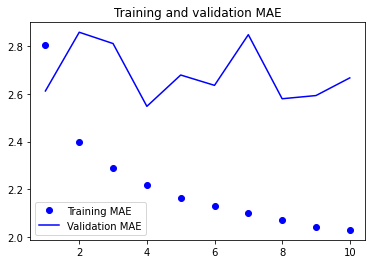

In [25]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")

plt.title("Training and validation MAE")
plt.legend()
plt.show()

- Some of the validation losses are close to the no-learning baseline, but not reliably.

- This goes to show the merit of having this baseline in the first place: it turns out to be
not easy to outperform. 

- Your common sense contains a lot of valuable information to which a machine learning model doesn’t have access.

## 1D convolutional model

- Since our input sequences feature daily cycles, perhaps a convolutional model could work. 

- A temporal convnet could reuse the same representations across different days, much like a spatial convnet can reuse the same representations across different locations in an image.

- You can build 1D convnets, strictly analogous to 2D convnets. 

- They’re a great fit for any sequence data that follows the translation invariance assumption (meaning that if you slide a window over the sequence, the content of the window should follow the same properties independently of the location of the window).

- Let’s try one on our temperature-forecasting problem. 

- We’ll pick an initial window length of 24, so that we look at 24 hours of data at a time (one cycle). 

- As we downsample the sequences (via MaxPooling1D layers), we’ll reduce the window size accordingly.

In [26]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)

x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)

x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)

outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)


In [27]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]


In [28]:
model.compile(optimizer="rmsprop", 
              loss="mse", 
              metrics=["mae"])

In [29]:
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 18s 21ms/step - loss: 22.4444 - mae: 3.7136 - val_loss: 22.1856 - val_mae: 3.7301
Epoch 2/10
819/819 [==============================] - 17s 21ms/step - loss: 15.5299 - mae: 3.1352 - val_loss: 15.8140 - val_mae: 3.1652
Epoch 3/10
819/819 [==============================] - 17s 21ms/step - loss: 14.4003 - mae: 3.0145 - val_loss: 14.5049 - val_mae: 3.0009
Epoch 4/10
819/819 [==============================] - 17s 21ms/step - loss: 13.5429 - mae: 2.9163 - val_loss: 15.5662 - val_mae: 3.0777
Epoch 5/10
819/819 [==============================] - 17s 21ms/step - loss: 12.9068 - mae: 2.8427 - val_loss: 15.0414 - val_mae: 3.0400
Epoch 6/10
819/819 [==============================] - 18s 21ms/step - loss: 12.4551 - mae: 2.7867 - val_loss: 13.8883 - val_mae: 2.9576
Epoch 7/10
819/819 [==============================] - 18s 21ms/step - loss: 12.0553 - mae: 2.7407 - val_loss: 14.3529 - val_mae: 2.9928
Epoch 8/10
819/819 [============================

In [30]:
model = keras.models.load_model("jena_conv.keras")

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 3s 8ms/step - loss: 15.3856 - mae: 3.1037
Test MAE: 3.10


- This model performs even worse than the densely connected one,

- We only achieve a validation MAE of about 3 degrees, far from the common-sense
baseline. 

- What went wrong here? Two things:
  - First, weather data doesn’t quite respect the translation invariance assumption. While the data does feature daily cycles, data from a morning follows different properties than data from an evening or from the middle of the night. Weather data is only translation-invariant for a very specific timescale.

  - Second, order in our data matters—a lot. The recent past is far more informative for predicting the next day’s temperature than data from five days ago. A 1D convnet is not able to leverage this fact. In particular, our max pooling and global average pooling layers are largely destroying order information.

## Recurrent neural networks: LSTM-based model

- The densely connected approach first flattened the timeseries, which removed the notion of time from the input data. 

- The convolutional approach treated every segment of the data in the same way, even applying pooling, which destroyed order information. 

- Let’s instead look at the data as what it is: a sequence, where causality and order matter.

- There’s a family of neural network architectures designed specifically for this use
case: recurrent neural networks. 

- Among them, the Long Short Term Memory (LSTM) layer has long been very popular.

In [31]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

x = layers.LSTM(16)(inputs)

outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

In [32]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]

In [33]:
model.compile(optimizer="rmsprop", 
              loss="mse", 
              metrics=["mae"])

In [34]:
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 33s 38ms/step - loss: 40.1362 - mae: 4.5977 - val_loss: 12.0617 - val_mae: 2.6626
Epoch 2/10
819/819 [==============================] - 30s 36ms/step - loss: 10.7800 - mae: 2.5560 - val_loss: 9.5589 - val_mae: 2.4105
Epoch 3/10
819/819 [==============================] - 30s 36ms/step - loss: 9.8158 - mae: 2.4471 - val_loss: 9.5597 - val_mae: 2.4216
Epoch 4/10
819/819 [==============================] - 30s 36ms/step - loss: 9.4428 - mae: 2.3991 - val_loss: 9.7182 - val_mae: 2.4355
Epoch 5/10
819/819 [==============================] - 30s 36ms/step - loss: 9.0972 - mae: 2.3520 - val_loss: 9.8284 - val_mae: 2.4453
Epoch 6/10
819/819 [==============================] - 29s 36ms/step - loss: 8.7998 - mae: 2.3121 - val_loss: 9.8863 - val_mae: 2.4535
Epoch 7/10
819/819 [==============================] - 30s 36ms/step - loss: 8.5702 - mae: 2.2812 - val_loss: 10.0695 - val_mae: 2.4665
Epoch 8/10
819/819 [==============================] - 30s 

In [35]:
model = keras.models.load_model("jena_lstm.keras")

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 5s 12ms/step - loss: 11.1261 - mae: 2.5961
Test MAE: 2.60


-  We achieve a validation MAE as low as 2.5961 degrees and a test MAE of 2.6 degrees. 

- The LSTM-based model can finally beat the common-sense baseline (albeit just by a bit, for now), demonstrating the value of machine learning on this task.

## Understanding recurrent neural networks

- A major characteristic of all neural networks you’ve seen so far, such as densely connected
networks and convnets, is that they have no memory. 

- Each input shown to them is processed independently, with no state kept between inputs. 

- With such networks,in order to process a sequence or a temporal series of data points, you have to show the entire sequence to the network at once: turn it into a single data point. 

- For instance, this is what we did in the densely connected network example: we flattened
our five days of data into a single large vector and processed it in one go. Such networks
are called feedforward networks.

- A recurrent neural network (RNN) processes sequences by iterating through the sequence elements and maintaining a state that contains information relative to what
it has seen so far. 

- In effect, an RNN is a type of neural network that has an internal loop

## A recurrent layer in Keras

- An RNN layer that can process sequences of any length

- It takes inputs of shape (batch_size, timesteps, input_features)

- All recurrent layers in Keras (SimpleRNN, LSTM, and GRU) can be run in two different
modes: they can return either full sequences of successive outputs for each timestep
(a rank-3 tensor of shape (batch_size, timesteps, output_features)) or
return only the last output for each input sequence (a rank-2 tensor of shape (batch_
size, output_features)). 

- These two modes are controlled by the return_sequences constructor argument

- An RNN layer that returns only its last output step**

In [36]:
num_features = 14
steps = 120

inputs = keras.Input(shape=(steps, num_features))

outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)

print(outputs.shape)

(None, 16)


- An RNN layer that returns its full output sequence

In [37]:
num_features = 14
steps = 120

inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)

print(outputs.shape)

(None, 120, 16)


**Stacking RNN layers**

- It’s sometimes useful to stack several recurrent layers one after the other in order to
increase the representational power of a network. 

- In such a setup, you have to get all of the intermediate layers to return a full sequence of outputs.

In [ ]:
inputs = keras.Input(shape=(steps, num_features))

x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)

outputs = layers.SimpleRNN(16)(x)

- In practice, you’ll rarely work with the SimpleRNN layer. It’s generally too simplistic to be of real use. 

- In particular, SimpleRNN has a major issue: although it should theoretically
be able to retain at time t information about inputs seen many timesteps before, such
long-term dependencies prove impossible to learn in practice. 

- This is due to the vanishing gradient problem, an effect that is similar to what is observed with non-recurrent networks (feedforward networks) that are many layers deep: as you keep adding layers to a network, the network eventually becomes untrainable

## Advanced use of recurrent neural networks

- Using recurrent dropout to fight overfitting

**Training and evaluating a dropout-regularized LSTM**

In [38]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [39]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]

In [40]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50, 
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/50
819/819 [==============================] - 54s 64ms/step - loss: 26.8157 - mae: 3.8247 - val_loss: 10.0694 - val_mae: 2.4593
Epoch 2/50
819/819 [==============================] - 52s 64ms/step - loss: 14.7295 - mae: 2.9791 - val_loss: 9.4813 - val_mae: 2.3867
Epoch 3/50
819/819 [==============================] - 54s 66ms/step - loss: 14.0210 - mae: 2.8980 - val_loss: 9.3239 - val_mae: 2.3670
Epoch 4/50
819/819 [==============================] - 53s 64ms/step - loss: 13.4708 - mae: 2.8364 - val_loss: 9.4147 - val_mae: 2.3825
Epoch 5/50
819/819 [==============================] - 54s 66ms/step - loss: 12.8856 - mae: 2.7784 - val_loss: 9.3276 - val_mae: 2.3795
Epoch 6/50
819/819 [==============================] - 52s 64ms/step - loss: 12.5006 - mae: 2.7377 - val_loss: 9.4144 - val_mae: 2.3856
Epoch 7/50
819/819 [==============================] - 53s 64ms/step - loss: 12.0924 - mae: 2.6934 - val_loss: 9.4523 - val_mae: 2.4001
Epoch 8/50
819/819 [==============================] - 

In [42]:
model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 7s 16ms/step - loss: 10.3666 - mae: 2.5408
Test MAE: 2.54


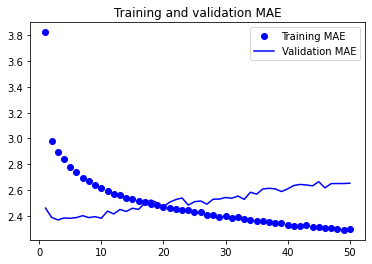

In [43]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")

plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Stacking recurrent layers with a GRU model

- Next, we’ll use Gated Recurrent Unit (GRU) layers instead of LSTM. 

- GRU is very similar to LSTM—you can think of it as a slightly simpler, streamlined version of the LSTM architecture.

- Training and evaluating a dropout-regularized, stacked GRU model

In [44]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

In [45]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]

In [46]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

In [47]:
history = model.fit(train_dataset,
                    epochs=15, # we use 15 instead of 50
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/15
819/819 [==============================] - 92s 108ms/step - loss: 26.6000 - mae: 3.7910 - val_loss: 9.3166 - val_mae: 2.3574
Epoch 2/15
819/819 [==============================] - 86s 105ms/step - loss: 14.0802 - mae: 2.9065 - val_loss: 9.4442 - val_mae: 2.3896
Epoch 3/15
819/819 [==============================] - 86s 105ms/step - loss: 13.2165 - mae: 2.8177 - val_loss: 8.9861 - val_mae: 2.3204
Epoch 4/15
819/819 [==============================] - 86s 105ms/step - loss: 12.5084 - mae: 2.7416 - val_loss: 8.8973 - val_mae: 2.3289
Epoch 5/15
819/819 [==============================] - 86s 105ms/step - loss: 12.0001 - mae: 2.6852 - val_loss: 9.1988 - val_mae: 2.3634
Epoch 6/15
819/819 [==============================] - 86s 105ms/step - loss: 11.6346 - mae: 2.6446 - val_loss: 10.0672 - val_mae: 2.4820
Epoch 7/15
819/819 [==============================] - 86s 104ms/step - loss: 11.3016 - mae: 2.6076 - val_loss: 9.7055 - val_mae: 2.4287
Epoch 8/15
819/819 [===========================

In [48]:
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 9s 21ms/step - loss: 9.8207 - mae: 2.4722
Test MAE: 2.47


### Using bidirectional RNNs

- The last technique we’ll look at is the bidirectional RNN. 

- A bidirectional RNN is a common RNN variant that can offer greater performance than a regular RNN on certain tasks. 

- It’s frequently used in natural language processing—you could call it the Swiss Army knife of deep learning for natural language processing

- You’ll find that it doesn’t perform as well as the plain LSTM layer since  all the predictive capacity must come from the chronological half of the
network, because the antichronological half is known to be severely underperforming
on this task (again, because the recent past matters much more than the distant past,
in this case). 

- At the same time, the presence of the antichronological half doubles the network’s capacity and causes it to start overfitting much earlier.

- However, bidirectional RNNs are a great fit for text data, or any other kind of data
where order matters, yet where which order you use doesn’t matter. 

- In fact, for a while in 2016, bidirectional LSTMs were considered the state of the art on many natural language processing tasks (before the rise of the Transformer architecture)

**Training and evaluating a bidirectional LSTM**

In [49]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

x = layers.Bidirectional(layers.LSTM(16))(inputs)

outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

In [50]:

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset)

Epoch 1/5
819/819 [==============================] - 39s 44ms/step - loss: 25.8332 - mae: 3.6772 - val_loss: 11.0329 - val_mae: 2.5763
Epoch 2/5
819/819 [==============================] - 41s 50ms/step - loss: 9.3958 - mae: 2.3961 - val_loss: 10.1830 - val_mae: 2.4680
Epoch 3/5
819/819 [==============================] - 37s 46ms/step - loss: 8.5552 - mae: 2.2780 - val_loss: 10.1725 - val_mae: 2.4703
Epoch 4/5
819/819 [==============================] - 35s 42ms/step - loss: 8.0000 - mae: 2.1981 - val_loss: 10.3795 - val_mae: 2.5004
Epoch 5/5
819/819 [==============================] - 38s 46ms/step - loss: 7.6410 - mae: 2.1488 - val_loss: 10.7315 - val_mae: 2.5576
